<a href="https://colab.research.google.com/github/alexsalman/CSE247/blob/main/2D_CNN%2BLSTM_(random_split).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**Convolutional Neural Network + Long Short Term Memory**
######*I am using a Convolution Neural Network (CNN) + Long Short Term Memory (LSTM) Network to extract general representation while utilizing the Spatial-temporal aspect of the videos.*

In [1]:
# required libraries
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, ConvLSTM2D, Reshape
from keras.layers.recurrent import LSTM
from PIL import Image
%matplotlib inline
print(tf.version.VERSION)
# https://bleedai.com/human-activity-recognition-using-tensorflow-cnn-lstm/

2.8.0


In [2]:
# set Numpy, Python, and Tensorflow seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# mount dataset from google drive
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/247/'
os.chdir(gdrive_path)
os.getcwd()

Mounted at /content/gdrive/


'/content/gdrive/My Drive/247'

In [4]:
# frame dimention
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
# frame number for each video (depth)
SEQUENCE_LENGTH = 16
# video dir path
DATASET_DIR = gdrive_path + 'Cropped_videos'
# labels of classes
CLASSES_LIST = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [5]:
# image cropping
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [6]:
# https://medium.com/analytics-vidhya/video-preprocessor-and-augmentation-for-deep-learning-tasks-12dd3fcce868
def load_video(path, resize=(128, 128)):
    video_reader = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = video_reader.read()
            if not ret:
                  break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        video_reader.release()
    return np.array(frames) / 255.0

In [9]:
def create_dataset():
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = load_video(video_file_path)
            features.append(frames)
            labels.append(class_index)
            video_files_paths.append(video_file_path)
  
    # Converting the list to numpy arrays
    features = np.asarray(features)
    # print(features)
    labels = np.array(labels)
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [10]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: hemostasis
Extracting Data of Class: inflammatory
Extracting Data of Class: proliferative
Extracting Data of Class: maturation


In [11]:
# one_hot_encoded_labels
one_hot_encoded_labels = keras.utils.to_categorical(labels)

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [13]:
def create_convlstm_model():
    imgSize = (128, 128)
    in_shape = (16, imgSize[0], imgSize[1], 3)
    model = Sequential()
    model.add(keras.layers.ConvLSTM2D(32, kernel_size=(3, 3), padding='valid', return_sequences=True, input_shape=in_shape))
    model.add(keras.layers.Activation('relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(keras.layers.ConvLSTM2D(16, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(keras.layers.ConvLSTM2D(16, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.ConvLSTM2D(16, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.ConvLSTM2D(16, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dense(16))
    model.add(keras.layers.Activation('relu'))
    model.add(Dropout(0.2))

    out_shape = model.output_shape
    print('====Model shape: ', out_shape)
    model.add(Reshape((16, out_shape[2] * out_shape[3] * out_shape[4])))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # model structure summary
    print(model.summary())

    return model
    # https://www.programcreek.com/python/?code=woodfrog%2FActionRecognition%2FActionRecognition-master%2Frnn_practice%2FLRCN_keras%2FLRCN_keras.py

In [14]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

====Model shape:  (None, 16, 12, 12, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 16, 126, 126, 32)  40448     
                                                                 
 activation (Activation)     (None, 16, 126, 126, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 63, 63, 32)   0         
 )                                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 16, 61, 61, 16)    27712     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 16, 30, 30, 16)   0         
 3D)                                                             
                                                                 
 conv_lstm2d_2 

In [ ]:
# keras.utils.plot_model(convlstm_model,
#                          to_file = 'convlstm_model_structure_plot.png',
#                          show_shapes = True,
#                          show_layer_names = True)

In [15]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                        patience = 10,
                                                        mode = 'min',
                                                        restore_best_weights = True)
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy',
                       optimizer = 'Adam',
                       metrics = ["accuracy"])
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train,
                                                     y = labels_train,
                                                     epochs = 10,
                                                     batch_size = 10,
                                                     shuffle = True,
                                                     validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/10
130/130 [==============================] - 158s 1s/step - loss: 0.9770 - accuracy: 0.5069 - val_loss: 0.7764 - val_accuracy: 0.6204
Epoch 2/10
130/130 [==============================] - 135s 1s/step - loss: 0.7742 - accuracy: 0.6412 - val_loss: 0.7438 - val_accuracy: 0.6389
Epoch 3/10
130/130 [==============================] - 136s 1s/step - loss: 0.7070 - accuracy: 0.6713 - val_loss: 0.6608 - val_accuracy: 0.6759
Epoch 4/10
130/130 [==============================] - 136s 1s/step - loss: 0.6378 - accuracy: 0.7045 - val_loss: 0.5847 - val_accuracy: 0.7654
Epoch 5/10
130/130 [==============================] - 136s 1s/step - loss: 0.5553 - accuracy: 0.7546 - val_loss: 0.5446 - val_accuracy: 0.7562
Epoch 6/10
130/130 [==============================] - 136s 1s/step - loss: 0.5547 - accuracy: 0.7731 - val_loss: 0.4639 - val_accuracy: 0.8086
Epoch 7/10
130/130 [==============================] - 136s 1s/step - loss: 0.4515 - accuracy: 0.8017 - val_loss: 0.4214 - val_accuracy: 0.8117

In [16]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

17/17 [==============================] - 12s 689ms/step - loss: 0.2852 - accuracy: 0.8870


In [18]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model_(random_split)__Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Change dir
gdrive_path = '/content/gdrive' + '/My Drive/247/Saved_models/'
os.chdir(gdrive_path)
# Create a floder for the model files
!mkdir -p convlstm_{current_date_time_string}
# Save your Model.
convlstm_model.save('convlstm_random_split' + str(current_date_time_string) + '/' + model_file_name)
# Save model weights
convlstm_model.save_weights('convlstm_' + str(current_date_time_string) + '/' + 'weights')

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

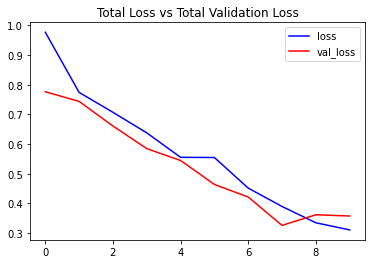

In [20]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

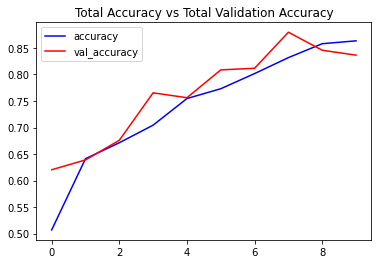

In [21]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 